# Simulating a Firing Rate Network Model

@[Chaoming Wang](https://github.com/chaoming0625)

Whole-brain modeling is the grand challenge of computational neuroscience. Simulating a whole-brain models with spiking neurons is still nearly impossible for normal users. However, by using rate-based neural mass models, in which each brain region is approximated to several simple variables, we can build an abstract whole-brain model. In recent years, whole-brain models can be used to address a wide range of problems. In this section, we are going to talk about how to simulate a whole-brain neural mass model with BrainPy.

In [1]:
import brainpy as bp
import brainpy.math as bm
from brainpy.dyn import rates

import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'plasma'

## Neural mass model

A neural mass models is a low-dimensional population model of spiking neural networks. It aims to describe the coarse grained activity of large populations of neurons and synapses. Mathematically, it is a dynamical system of non-linear ODEs. A classical neural mass model is the two dimensional [Wilson–Cowan model](https://en.wikipedia.org/wiki/Wilson%E2%80%93Cowan_model). This model tracks the activity of an excitatory population of neurons coupled to an inhibitory population. With the augmentation of such models by more realistic forms of synaptic and network interaction they have proved especially successful in providing fits to neuro-imaging data.

Here, let's try the Wilson-Cowan model.

  0%|          | 0/100 [00:00<?, ?it/s]

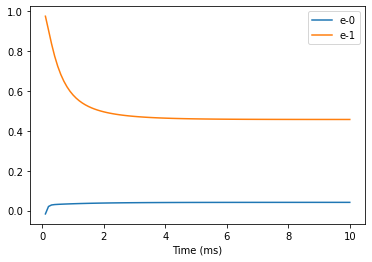

In [2]:
wc = rates.WilsonCowanModel(2,
                            wEE=16., wIE=15., wEI=12., wII=3.,
                            E_a=1.5, I_a=1.5, E_theta=3., I_theta=3.,
                            method='exp_euler_auto')
wc.x[:] = [-0.2, 1.]
wc.y[:] = [0.0, 1.]

runner = bp.dyn.DSRunner(wc, monitors=['x', 'y'], inputs=['input', -0.5])
runner.run(10.)

bp.visualize.line_plot(runner.mon.ts, runner.mon.x,
                       plot_ids=[0, 1], legend='e', show=True)

We can see this model at least has two stable states.

**Bifurcation diagram**

With the automatic analysis module in BrainPy, we can easily inspect the bifurcation digram of the model. Bifurcation diagrams can give us an overview of how different parameters of the model affect its dynamics (the details of the automatic analysis support of BrainPy please see the introduction in [Analyzing a Dynamical Model](./analysis.ipynb) and tutorials in [Dynamics Analysis](../tutorial_analysis/index.rst)). In this case, we make ``x_ext`` as a bifurcation parameter, and try to see how the system behavior changes with the change of ``x_ext``.

I am making bifurcation analysis ...
I am filtering out fixed point candidates with auxiliary function ...
I am trying to find fixed points by optimization ...
	There are 40000 candidates
I am trying to filter out duplicate fixed points ...
	Found 579 fixed points.
I am plotting the limit cycle ...
C:\Users\adadu\miniconda3\lib\site-packages\jax\_src\numpy\lax_numpy.py:1868: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "asarray")


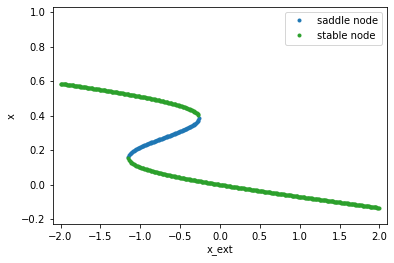

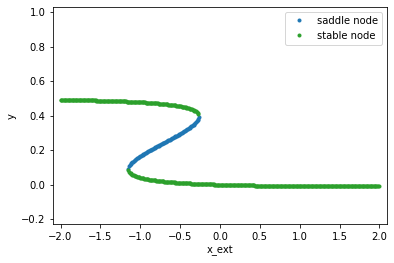

In [3]:
bf = bp.analysis.Bifurcation2D(
    wc,
    target_vars={'x': [-0.2, 1.], 'y': [-0.2, 1.]},
    target_pars={'x_ext': [-2, 2]},
    pars_update={'y_ext': 0.},
    resolutions={'x_ext': 0.01}
)
bf.plot_bifurcation()
bf.plot_limit_cycle_by_sim(duration=500)
bf.show_figure()

Similarly, simulating and analyzing a rate-based FitzHugh-Nagumo model is also a piece of cake by using BrainPy.

I am making bifurcation analysis ...
I am filtering out fixed point candidates with auxiliary function ...
I am trying to find fixed points by optimization ...
	There are 20000 candidates
I am trying to filter out duplicate fixed points ...
	Found 200 fixed points.
I am plotting the limit cycle ...
C:\Users\adadu\miniconda3\lib\site-packages\jax\_src\numpy\lax_numpy.py:1868: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "asarray")


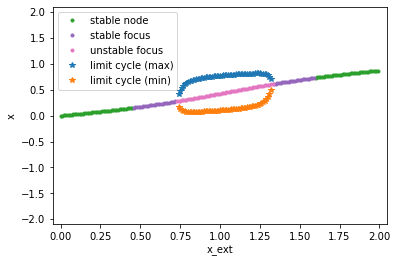

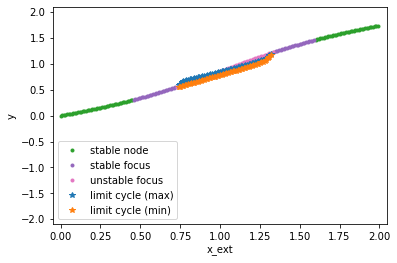

In [4]:
fhn = rates.FHN(1, method='exp_auto')

bf = bp.analysis.Bifurcation2D(
    fhn,
    target_vars={'x': [-2, 2], 'y': [-2, 2]},
    target_pars={'x_ext': [0, 2]},
    pars_update={'y_ext': 0.},
    resolutions={'x_ext': 0.01}
)
bf.plot_bifurcation()
bf.plot_limit_cycle_by_sim(duration=500)
bf.show_figure()

In this model, we find that when the external input ``x_ext`` has the value in [0.72, 1.4], the model will generate limit cycles. We can verify this by simulation.

  0%|          | 0/1000 [00:00<?, ?it/s]

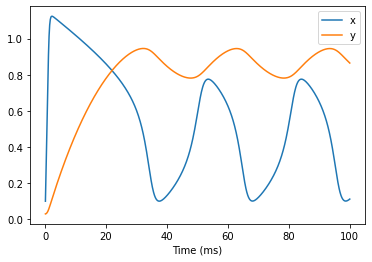

In [5]:
runner = bp.dyn.DSRunner(fhn, monitors=['x', 'y'], inputs=['input', 1.0])
runner.run(100.)

bp.visualize.line_plot(runner.mon.ts, runner.mon.x, legend='x')
bp.visualize.line_plot(runner.mon.ts, runner.mon.y, legend='y', show=True)

## Whole-brain model

A rate-based whole-brain model is a network model which consists of coupled brain regions. Each brain region is represented by a neural mass model which is connected to other brain regions according to the underlying network structure of the brain, also known as the connectome. In order to illustrate how to use BrainPy's support for whole-brain modeling, here we provide a processed data in the following link:

- A processed data from ConnectomeDB of the Human Connectome Project (HCP): [https://share.weiyun.com/wkPpARKy](https://share.weiyun.com/wkPpARKy)

Please download the dataset and place it in your favorite ``PATH``.

In [6]:
PATH = './data/hcp.npz'

In genral, a dataset for whole-brain modeling consists of the following parts:

1\. A structural connectivity matrix which captures the synaptic connection strengths between brain areas. It often derived from DTI tractography of the whole brain. The connectome is then typically parcellated in a preferred atlas (for example the AAL2 atlas) and the number of axonal fibers connecting each brain area with every other area is counted. This number serves as an indication of the synaptic coupling strengths between the areas of the brain.

2\. A delay matrix which calculated from the average length of the axonal fibers connecting each brain area with another.

3\. A set of functional data that can act as a target for model optimization. Resting-state fMRI offers an easy and fairly unbiased way for calibrating whole-brain models. EEG data could be used as well.

Now, let's load the dataset.

In [7]:
data = bm.load(PATH)

In [8]:
# The structural connectivity matrix

data['Cmat'].shape

(80, 80)

In [9]:
# The fiber length matrix

data['Dmat'].shape

(80, 80)

In [10]:
# The functional data for 7 subjects

data['FCs'].shape

(7, 80, 80)

Let's have a look what the data looks like.

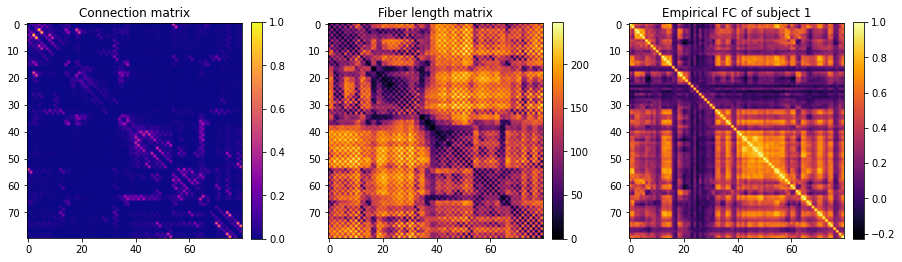

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
fig.subplots_adjust(wspace=0.28)

im = axs[0].imshow(data['Cmat'])
axs[0].set_title("Connection matrix")
fig.colorbar(im, ax=axs[0],fraction=0.046, pad=0.04)
im = axs[1].imshow(data['Dmat'], cmap='inferno')
axs[1].set_title("Fiber length matrix")
fig.colorbar(im, ax=axs[1],fraction=0.046, pad=0.04)
im = axs[2].imshow(data['FCs'][0], cmap='inferno')
axs[2].set_title("Empirical FC of subject 1")
fig.colorbar(im, ax=axs[2],fraction=0.046, pad=0.04)
plt.show()

Let's first get the delay matrix according to the fiber length matrix, the signal transmission speed between areas, and the numerical integration step ``dt``. Here, we assume the axonal transmission speed is 20 and the simulation time step ``dt=0.1`` ms.

In [12]:
sigal_speed = 20.

# the number of the delay steps
delay_mat = data['Dmat'] / sigal_speed / bm.get_dt()
delay_mat = bm.asarray(delay_mat, dtype=bm.int_)

The connectivity matrix can be directly obtained through the structural connectivity matrix, which times a global coupling strength parameter ``gc``. b

In [13]:
gc = 1.

conn_mat = bm.asarray(data['Cmat'] * gc)

# It is necessary to exclude the self-connections
bm.fill_diagonal(conn_mat, 0)

We now are ready to intantiate a whole-brain model with the neural mass model and the dataset the processed before.

In [14]:
class WholeBrainNet(bp.dyn.Network):
  def __init__(self, Cmat, Dmat):
    super(WholeBrainNet, self).__init__()

    self.fhn = rates.FHN(80, x_ou_sigma=0.01, y_ou_sigma=0.01,
                              name='fhn', method='exp_auto')
    self.syn = rates.DiffusiveCoupling(self.fhn.x, self.fhn.x, self.fhn.input,
                                       conn_mat=Cmat,
                                       delay_steps=Dmat.astype(bm.int_),
                                       initial_delay_data=bp.init.Uniform(0, 0.05))

  def update(self, _t, _dt):
    self.syn.update(_t, _dt)
    self.fhn.update(_t, _dt)

In [15]:
net = WholeBrainNet(conn_mat, delay_mat)

runner = bp.dyn.DSRunner(net, monitors=['fhn.x'], inputs=['fhn.input', 0.72])
runner.run(6e3)

  0%|          | 0/60000 [00:00<?, ?it/s]

6.346501350402832

The simulated results can be used to estimate the functional correlation matrix.

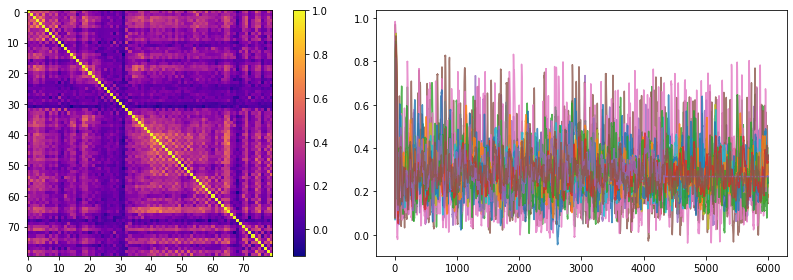

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fc = bp.measure.functional_connectivity(runner.mon['fhn.x'])
ax = axs[0].imshow(fc)
plt.colorbar(ax, ax=axs[0])
axs[1].plot(runner.mon.ts, runner.mon['fhn.x'][:, ::5], alpha=0.8)
plt.tight_layout()
plt.show()

We can compute the element-wise Pearson correlation of the functional connectivity matrices of the simulated data to the empirical data to estimate how well the model captures the inter-areal functional correlations found in empirical resting-state recordings.

In [17]:
scores = [bp.measure.matrix_correlation(fc, fcemp)
          for fcemp in data['FCs']]
print("Correlation per subject:", [f"{s:.2}" for s in scores])
print("Mean FC/FC correlation: {:.2f}".format(bm.mean(bm.asarray(scores))))

Correlation per subject: ['0.58', '0.45', '0.55', '0.49', '0.54', '0.5', '0.45']
Mean FC/FC correlation: 0.51
